In [61]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import time
import torch.optim as optim
from tqdm import tqdm
from torch.optim import lr_scheduler

In [62]:
#Allow autofill on kaggle
%config Completer.use_jedi = False

In [63]:
# Helper functions to load data into gpu if available

def get_default_device():
  #Pick GPU if available, else CPU
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  #Move tensor(s) to chosen device
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    #Wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
      
    def __iter__(self):
    #Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
    #Number of batches
        return len(self.dl)

In [64]:
#Loading Dataset
transform = Compose(
    [ToTensor(),
     Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

dataset = CIFAR10(root='data/', train=True,download=True, transform=transform)

val_size = 8000
train_size = len(dataset) - val_size
trainset, valset = random_split(dataset, [train_size, val_size])
trainloader = DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=4, pin_memory = True)
valloader = DataLoader(valset, batch_size=batch_size, num_workers=4, pin_memory=True)

testset = CIFAR10(root='data/', train=False,download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=4, pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = get_default_device()
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda


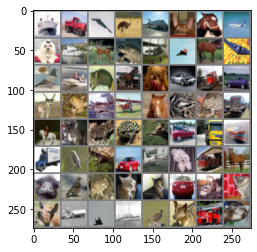

ship  truck plane bird  plane dog   horse plane dog   ship  deer  frog  plane plane horse plane bird  ship  cat   horse dog   car   truck car   deer  frog  plane plane horse frog  frog  truck horse cat   frog  frog  deer  car   truck ship  truck bird  frog  car   plane dog   truck horse bird  bird  frog  cat   cat   car   truck cat   deer  truck plane ship  bird  dog   truck cat  


In [65]:
#Showing few images in the loaded data
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [66]:
#CNN with 3 convolutional layers and 3 linear layers
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 =  nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)        
        self.fc1 = nn.Linear(64*4*4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 =  nn.Linear(64, 10)
        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = self.criterion(out, labels) # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return loss, acc

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = self.criterion(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], Time taken :{:.4f}, train_loss : {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [67]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(to_device(batch,device)) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, model, train_loader, val_loader, lr=0.1,momentum = 0):
    history = []
    lrs = []
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    end = 0
    scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    for epoch in range(epochs):
        # Training Phase 
        train_losses = []
        train_accuracy = []
        start = time.time()
        for batch in tqdm(train_loader):
            batch = to_device(batch, device)
            loss,acc= model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(acc)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result =  evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        end = time.time()
        result['time'] = end - start
        model.epoch_end(epoch, result)
        history.append(result)
        lrs.append(scheduler.get_last_lr())
        scheduler.step()
    return history, end, lrs

In [68]:
begin = time.time()
history, end, lrs = fit(30, net, trainloader, valloader)
print('Finished Training in '+ str(end-begin) + 'secs')

100%|██████████| 657/657 [00:09<00:00, 66.61it/s]


Epoch [0], Time taken :11.6031, train_loss : 2.0954, train_acc: 0.2116, val_loss: 1.8402, val_acc: 0.3133


100%|██████████| 657/657 [00:09<00:00, 66.52it/s]


Epoch [1], Time taken :11.7113, train_loss : 1.6443, train_acc: 0.3966, val_loss: 1.6431, val_acc: 0.4153


100%|██████████| 657/657 [00:10<00:00, 61.85it/s]


Epoch [2], Time taken :12.7600, train_loss : 1.4294, train_acc: 0.4828, val_loss: 1.6383, val_acc: 0.4271


100%|██████████| 657/657 [00:09<00:00, 68.96it/s]


Epoch [3], Time taken :11.6629, train_loss : 1.2865, train_acc: 0.5427, val_loss: 1.3215, val_acc: 0.5340


100%|██████████| 657/657 [00:09<00:00, 67.16it/s]


Epoch [4], Time taken :12.0968, train_loss : 1.1739, train_acc: 0.5867, val_loss: 1.5335, val_acc: 0.4881


100%|██████████| 657/657 [00:09<00:00, 67.65it/s]


Epoch [5], Time taken :11.5082, train_loss : 1.0819, train_acc: 0.6255, val_loss: 1.1740, val_acc: 0.5966


100%|██████████| 657/657 [00:09<00:00, 66.84it/s]


Epoch [6], Time taken :11.5759, train_loss : 1.0015, train_acc: 0.6547, val_loss: 1.0510, val_acc: 0.6326


100%|██████████| 657/657 [00:10<00:00, 63.57it/s]


Epoch [7], Time taken :12.1315, train_loss : 0.9323, train_acc: 0.6807, val_loss: 1.0041, val_acc: 0.6591


100%|██████████| 657/657 [00:09<00:00, 65.82it/s]


Epoch [8], Time taken :11.7708, train_loss : 0.8717, train_acc: 0.7028, val_loss: 0.9938, val_acc: 0.6662


100%|██████████| 657/657 [00:09<00:00, 67.73it/s]


Epoch [9], Time taken :11.4387, train_loss : 0.8178, train_acc: 0.7231, val_loss: 0.9886, val_acc: 0.6684


100%|██████████| 657/657 [00:10<00:00, 61.97it/s]


Epoch [10], Time taken :12.3422, train_loss : 0.7675, train_acc: 0.7398, val_loss: 1.0147, val_acc: 0.6691


100%|██████████| 657/657 [00:09<00:00, 66.84it/s]


Epoch [11], Time taken :11.5776, train_loss : 0.7277, train_acc: 0.7501, val_loss: 0.9015, val_acc: 0.6957


100%|██████████| 657/657 [00:09<00:00, 67.12it/s]


Epoch [12], Time taken :11.5246, train_loss : 0.6859, train_acc: 0.7662, val_loss: 1.0060, val_acc: 0.6801


100%|██████████| 657/657 [00:10<00:00, 62.98it/s]


Epoch [13], Time taken :12.2868, train_loss : 0.6451, train_acc: 0.7799, val_loss: 0.9014, val_acc: 0.7061


100%|██████████| 657/657 [00:09<00:00, 67.35it/s]


Epoch [14], Time taken :11.6410, train_loss : 0.6144, train_acc: 0.7925, val_loss: 0.9108, val_acc: 0.7038


100%|██████████| 657/657 [00:10<00:00, 63.92it/s]


Epoch [15], Time taken :12.6088, train_loss : 0.5772, train_acc: 0.8028, val_loss: 1.1179, val_acc: 0.6680


100%|██████████| 657/657 [00:09<00:00, 67.94it/s]


Epoch [16], Time taken :11.5062, train_loss : 0.5537, train_acc: 0.8123, val_loss: 0.9197, val_acc: 0.7080


100%|██████████| 657/657 [00:09<00:00, 66.81it/s]


Epoch [17], Time taken :11.8786, train_loss : 0.5300, train_acc: 0.8198, val_loss: 0.9605, val_acc: 0.6999


100%|██████████| 657/657 [00:10<00:00, 63.61it/s]


Epoch [18], Time taken :12.0894, train_loss : 0.4965, train_acc: 0.8302, val_loss: 0.9228, val_acc: 0.7129


100%|██████████| 657/657 [00:09<00:00, 67.62it/s]


Epoch [19], Time taken :11.4702, train_loss : 0.4783, train_acc: 0.8384, val_loss: 0.9133, val_acc: 0.7230


100%|██████████| 657/657 [00:09<00:00, 67.00it/s]


Epoch [20], Time taken :11.6729, train_loss : 0.4621, train_acc: 0.8436, val_loss: 0.9416, val_acc: 0.7199


100%|██████████| 657/657 [00:10<00:00, 63.67it/s]


Epoch [21], Time taken :12.1199, train_loss : 0.4419, train_acc: 0.8491, val_loss: 0.9443, val_acc: 0.7166


100%|██████████| 657/657 [00:09<00:00, 66.88it/s]


Epoch [22], Time taken :11.6524, train_loss : 0.4280, train_acc: 0.8525, val_loss: 0.9402, val_acc: 0.7254


100%|██████████| 657/657 [00:09<00:00, 66.18it/s]


Epoch [23], Time taken :12.2977, train_loss : 0.4062, train_acc: 0.8625, val_loss: 0.9911, val_acc: 0.7140


100%|██████████| 657/657 [00:10<00:00, 64.92it/s]


Epoch [24], Time taken :12.0206, train_loss : 0.3975, train_acc: 0.8651, val_loss: 0.9917, val_acc: 0.7157


100%|██████████| 657/657 [00:09<00:00, 67.63it/s]


Epoch [25], Time taken :11.4540, train_loss : 0.3821, train_acc: 0.8694, val_loss: 0.9594, val_acc: 0.7278


100%|██████████| 657/657 [00:10<00:00, 63.92it/s]


Epoch [26], Time taken :12.1168, train_loss : 0.3717, train_acc: 0.8733, val_loss: 0.9729, val_acc: 0.7250


100%|██████████| 657/657 [00:09<00:00, 68.59it/s]


Epoch [27], Time taken :11.6174, train_loss : 0.3627, train_acc: 0.8779, val_loss: 0.9667, val_acc: 0.7325


100%|██████████| 657/657 [00:09<00:00, 69.08it/s]


Epoch [28], Time taken :11.5999, train_loss : 0.3469, train_acc: 0.8826, val_loss: 0.9891, val_acc: 0.7249


100%|██████████| 657/657 [00:10<00:00, 60.73it/s]


Epoch [29], Time taken :12.8549, train_loss : 0.3439, train_acc: 0.8826, val_loss: 0.9832, val_acc: 0.7255
Finished Training in 356.9913880825043secs


In [69]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

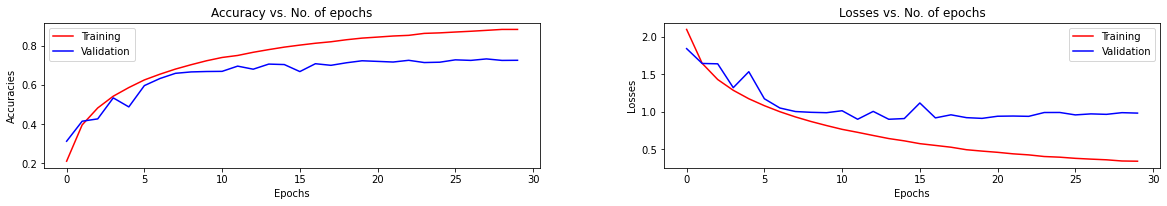

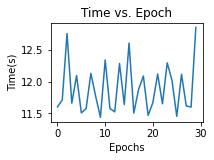

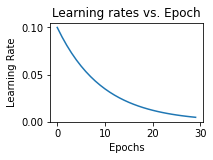

In [70]:
def plot_results(history, lrs):
    val_accs = [x['val_acc'] for x in history]
    train_accs = [x['train_acc'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_losses = [x['train_loss'] for x in history] 
    time_taken = [x['time'] for x in history]
    plt.figure(figsize=(20,6))
    plt.subplots_adjust(wspace= 0.25, hspace= 0.25)
    plt.subplot(221)
    plt.plot(train_accs, '-r')
    plt.plot(val_accs, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracies')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs')
    
    plt.subplot(222)
    plt.plot(train_losses, '-r')
    plt.plot(val_losses, '-b')
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Losses')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs. No. of epochs')
    plt.show()
    
    plt.subplot(223)
    plt.plot(time_taken)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Time(s)')
    plt.title('Time vs. Epoch')
    plt.show()
    
    plt.subplot(224)
    plt.plot(lrs)
    ax = plt.gca()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Learning Rate')
    plt.title('Learning rates vs. Epoch')
    plt.show()
              
plot_results(history, lrs)

In [71]:
net = Net()
net.load_state_dict(torch.load(PATH))
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (criterion): CrossEntropyLoss()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [72]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 72 %


In [73]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        data = to_device(data, device)
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 77.6 %
Accuracy for class: car   is 83.3 %
Accuracy for class: bird  is 61.9 %
Accuracy for class: cat   is 50.4 %
Accuracy for class: deer  is 67.4 %
Accuracy for class: dog   is 61.0 %
Accuracy for class: frog  is 79.5 %
Accuracy for class: horse is 77.3 %
Accuracy for class: ship  is 83.1 %
Accuracy for class: truck is 79.5 %
